<a href="https://colab.research.google.com/github/DT2024/Cifar_10_VAE/blob/main/Cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [ ]:
#Downloading and loading CIFAR 10
#Load CIFAR-10 dataset
transform=transforms.Compose([transforms.ToTensor()])
trainset=torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True)

100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
for X,y in trainloader:
  X=X[:7,:]
  print(X.size())
  break

torch.Size([7, 3, 32, 32])


In [ ]:
conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
for images, labels in trainloader:
    out_conv1 = conv1(images)
    print(out_conv1.shape)
    break

torch.Size([32, 16, 14, 14])


In [ ]:
conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
for images, labels in trainloader:
    out_conv2 = conv2(out_conv1)
    print(out_conv2.shape)
    break

torch.Size([32, 32, 5, 5])


In [ ]:
flatten = out_conv2.reshape((trainloader.batch_size, -1))

In [ ]:
flatten.shape

torch.Size([32, 800])

In [ ]:
#Creating VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()

        # Encoder Layers

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.linear1 = nn.Linear(800,500)
        self.mu = nn.Linear(500, 16) # latent_size = 16
        self.logvar = nn.Linear(500, 16)



        # Decoder Layers

        self.linear2 = nn.Linear(16, 500)
        self.linear3 = nn.Linear(500, 800)
        self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=5,stride=2)
        self.conv4 = nn.ConvTranspose2d(16, 3, kernel_size=5, stride=2)
        self.conv5 = nn.ConvTranspose2d(3, 3, kernel_size=4)



    def encoder(self,x):
        t = F.relu(self.conv1(x))
        t = F.relu(self.conv2(t))
        t = t.reshape((x.shape[0], -1))

        t = F.relu(self.linear1(t))
        mu = self.mu(t)
        logvar = self.logvar(t)
        return mu, logvar

    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std).to(device)
        return eps*std + mu

    def unFlatten(self, x):
        return x.reshape((x.shape[0], 32, 5, 5))

    def decoder(self, z):
        t = F.relu(self.linear2(z))
        t = F.relu(self.linear3(t))
        t = self.unFlatten(t)
        t = F.relu(self.conv3(t))
        t = F.relu(self.conv4(t))
        t = torch.sigmoid(self.conv5(t))
        return t


    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterization(mu,logvar)
        pred = self.decoder(z)
        return pred, mu, logvar

In [ ]:
def loss_func(reconstructed_image, original_image, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_image, original_image, reduction = 'sum') # BCE Loss for image reconstruction
    DKL = -0.5 * torch.sum(-logvar.exp() - mu.pow(2) + 1 + logvar) # kld loss for reduccing similarities b/w distributions.
    return BCE + DKL # sum of all the losses

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [ ]:
model

VAE(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (linear1): Linear(in_features=800, out_features=500, bias=True)
  (mu): Linear(in_features=500, out_features=16, bias=True)
  (logvar): Linear(in_features=500, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=500, bias=True)
  (linear3): Linear(in_features=500, out_features=800, bias=True)
  (conv3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv4): ConvTranspose2d(16, 3, kernel_size=(5, 5), stride=(2, 2))
  (conv5): ConvTranspose2d(3, 3, kernel_size=(4, 4), stride=(1, 1))
)

In [ ]:
epochs = 21001

losses = torch.zeros(epochs)

for epoch in range(epochs):

  # Selecting a batchsize  of 32.

  random_idx = np.random.choice(len(trainloader.dataset), size=32)
  X=[]
  for i in random_idx:
    img, _=trainloader.dataset[i]
    X.append(img)
  X=torch.stack(X, dim=0).to(device)
  predicted, mu, logvar = model(X)
  loss = loss_func(predicted, X, mu, logvar)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  losses[epoch] = loss.item()

  if (epoch % 1000) == 0:

      print(f' epochs : {epoch}  loss : {loss : 2.2f}')

 epochs : 0  loss :  68369.02
 epochs : 1000  loss :  63395.56
 epochs : 2000  loss :  60924.02
 epochs : 3000  loss :  59112.09
 epochs : 4000  loss :  58030.34
 epochs : 5000  loss :  60398.70
 epochs : 6000  loss :  58187.26
 epochs : 7000  loss :  59787.73
 epochs : 8000  loss :  58599.42
 epochs : 9000  loss :  60401.16
 epochs : 10000  loss :  60170.86
 epochs : 11000  loss :  61163.05
 epochs : 12000  loss :  57546.27
 epochs : 13000  loss :  58488.36
 epochs : 14000  loss :  57830.14
 epochs : 15000  loss :  58872.48
 epochs : 16000  loss :  57657.82
 epochs : 17000  loss :  58050.93
 epochs : 18000  loss :  58709.80
 epochs : 19000  loss :  60043.51
 epochs : 20000  loss :  60031.68
 epochs : 21000  loss :  57471.55


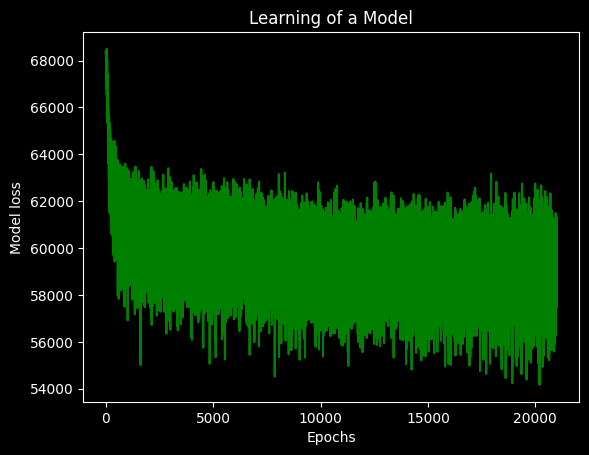

In [ ]:
plt.plot(losses, color = 'g', ls = '-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Learning of a Model')
plt.show()

In [ ]:
def smooth(x,k=7):
  return np.convolve(x,np.ones(k)/k,mode='same')

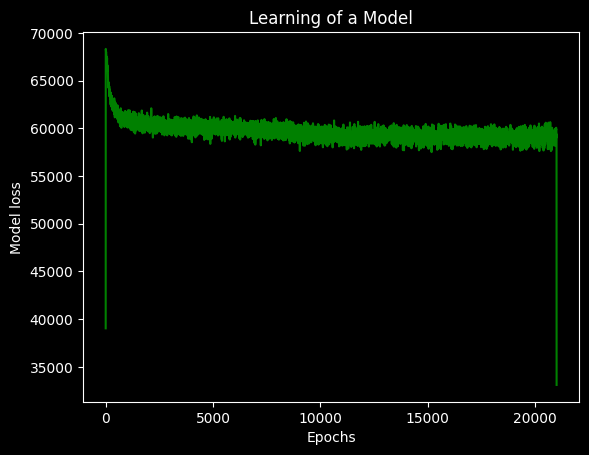

In [ ]:
plt.plot(smooth(losses), color = 'g', ls = '-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Learning of a Model')
plt.show()

In [ ]:
#Model testing
first_seven_samples = [trainloader.dataset[i][0] for i in range(7)]
X = torch.stack(first_seven_samples).to(device)
ypred, mu, logvar = model(X)

In [ ]:
ypred.shape

torch.Size([7, 3, 32, 32])

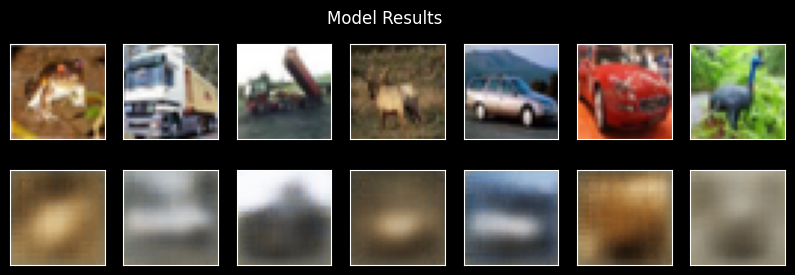

In [ ]:
#Visualising Model Performance
fig, axes = plt.subplots(2, 7, figsize=(10, 3))

for i in range(7):
      original_image=X[i].permute(1,2,0).detach().cpu()
      reconstructed_image=ypred[i].permute(1,2,0).detach().cpu()
      axes[0, i].imshow(original_image)
      axes[0, i].set_xticks([]), axes[0, i].set_yticks([])
      axes[1, i].imshow(reconstructed_image)
      axes[1, i].set_xticks([]), axes[1, i].set_yticks([])

plt.suptitle('Model Results')
plt.show()

In [ ]:
#Generating 7 samples and Checking Decoder Performance
sample = torch.randn(7,16)

In [ ]:
y_pred = model.decoder(sample.to(device))

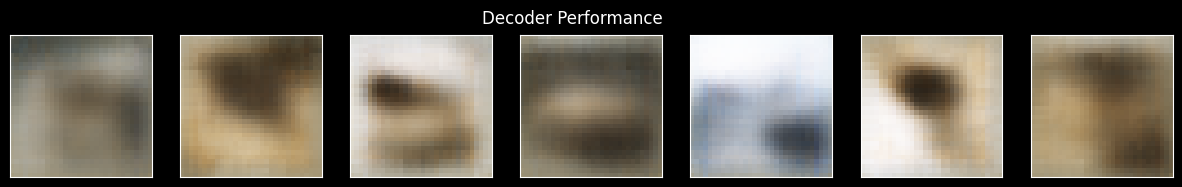

In [ ]:
fig,axes = plt.subplots(1,7,figsize=(15,2))

for i in range(7):
  axes[i].imshow(y_pred[i,:].permute(1,2,0).detach().cpu() ,cmap='gray')
  axes[i].set_xticks([]), axes[i].set_yticks([])
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.suptitle('Decoder Performance')
plt.show()

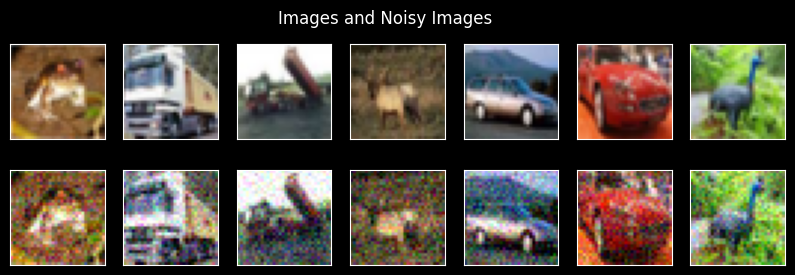

In [ ]:
#Denoising
# Get the first seven samples from the dataset
first_seven_samples = [trainloader.dataset[i][0] for i in range(7)]
X = torch.stack(first_seven_samples)

# Adding Gaussian Noise to the Images
noise_level = 0.1
Xnoise = X + noise_level * torch.randn(X.shape)
Xnoise = torch.clip(Xnoise, 0, 1)
Xnoise = Xnoise.to(device)

fig, axes = plt.subplots(2, 7, figsize=(10, 3))

for i in range(7):
    axes[0, i].imshow(X[i].permute(1, 2, 0).detach().cpu())
    axes[1, i].imshow(Xnoise[i].permute(1, 2, 0).detach().cpu())
    axes[0, i].set_xticks([]), axes[0, i].set_yticks([])
    axes[1, i].set_xticks([]), axes[1, i].set_yticks([])

plt.suptitle('Images and Noisy Images')
plt.show()

In [ ]:
ypred_noise = model(Xnoise)

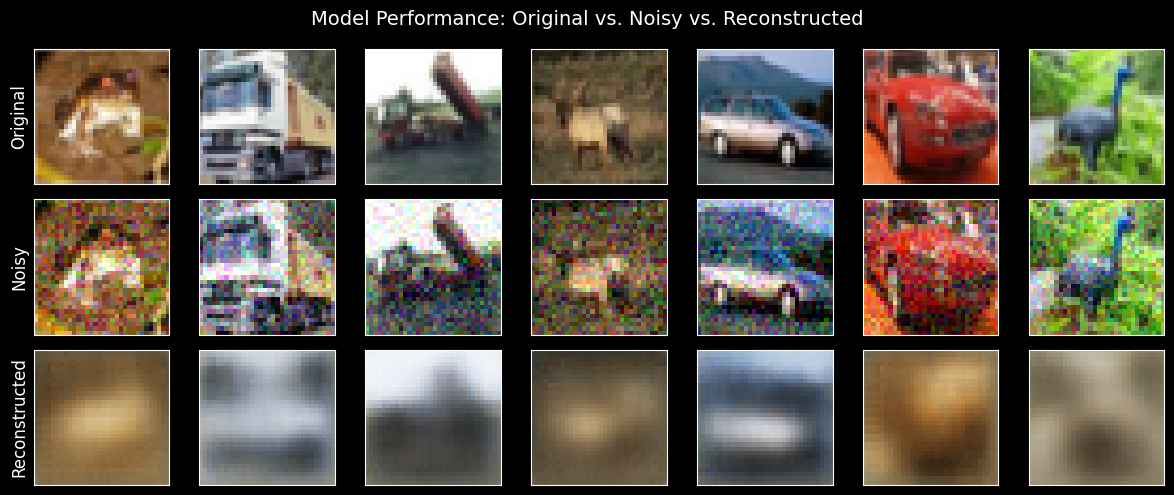

In [ ]:
fig, axes = plt.subplots(3, 7, figsize=(12, 5))

for i in range(7):
    # Extract images
    original = X[i].permute(1, 2, 0).cpu().detach()
    noisy = Xnoise[i].permute(1, 2, 0).cpu().detach()
    reconstructed = ypred_noise[0][i].permute(1, 2, 0).cpu().detach()

    # Display images
    axes[0, i].imshow(original)
    axes[1, i].imshow(noisy)
    axes[2, i].imshow(reconstructed)

    # Remove axis ticks
    axes[0, i].set_xticks([]), axes[0, i].set_yticks([])
    axes[1, i].set_xticks([]), axes[1, i].set_yticks([])
    axes[2, i].set_xticks([]), axes[2, i].set_yticks([])

# Set row labels
axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel("Noisy", fontsize=12)
axes[2, 0].set_ylabel("Reconstructed", fontsize=12)

plt.suptitle("Model Performance: Original vs. Noisy vs. Reconstructed", fontsize=14)
plt.tight_layout()
plt.show()
